In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from mhm_dataprocessing import *

#font segoe ui
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

#### Read data

In [2]:
mhm_flux_data = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mhm_RMI\mhm_mon_fluxes.nc")

#shapefile mask
be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be.shp")


#### Read data and clip to BE

In [3]:
be_data = clip_to_region(be_shp, mhm_flux_data)

#resample to month ends
#resample fluxes to month ends
variables = ['SM_L01','SM_L02','SM_L03','SM_Lall','SWC_L01','SWC_L02','SWC_L03','recharge']

mhm_fluxes_mon= be_data[variables].resample(time='M').mean()

c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


#### SMI and drought characteristics

In [4]:
#compute anomalies
#extract summer period JJA
summer_months = [6,7,8]
#extract values for summer months
data_summer = mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month.isin(summer_months))

#average soil moisture for summer months for each year
data_summer_avg = data_summer.groupby('time.year').mean()


### compute anomalies

In [5]:
monthly_anomalies = compute_standardized_anomaly(mhm_fluxes_mon, 'M')

c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [6]:
#extract summer anomalies
summer_months = [6,7,8]

summer_anomalies = monthly_anomalies.sel(time=mhm_fluxes_mon.time.dt.month.isin(summer_months))

In [7]:
#aggregate yearly
summer_average_anomaly = summer_anomalies.groupby('time.year').mean()

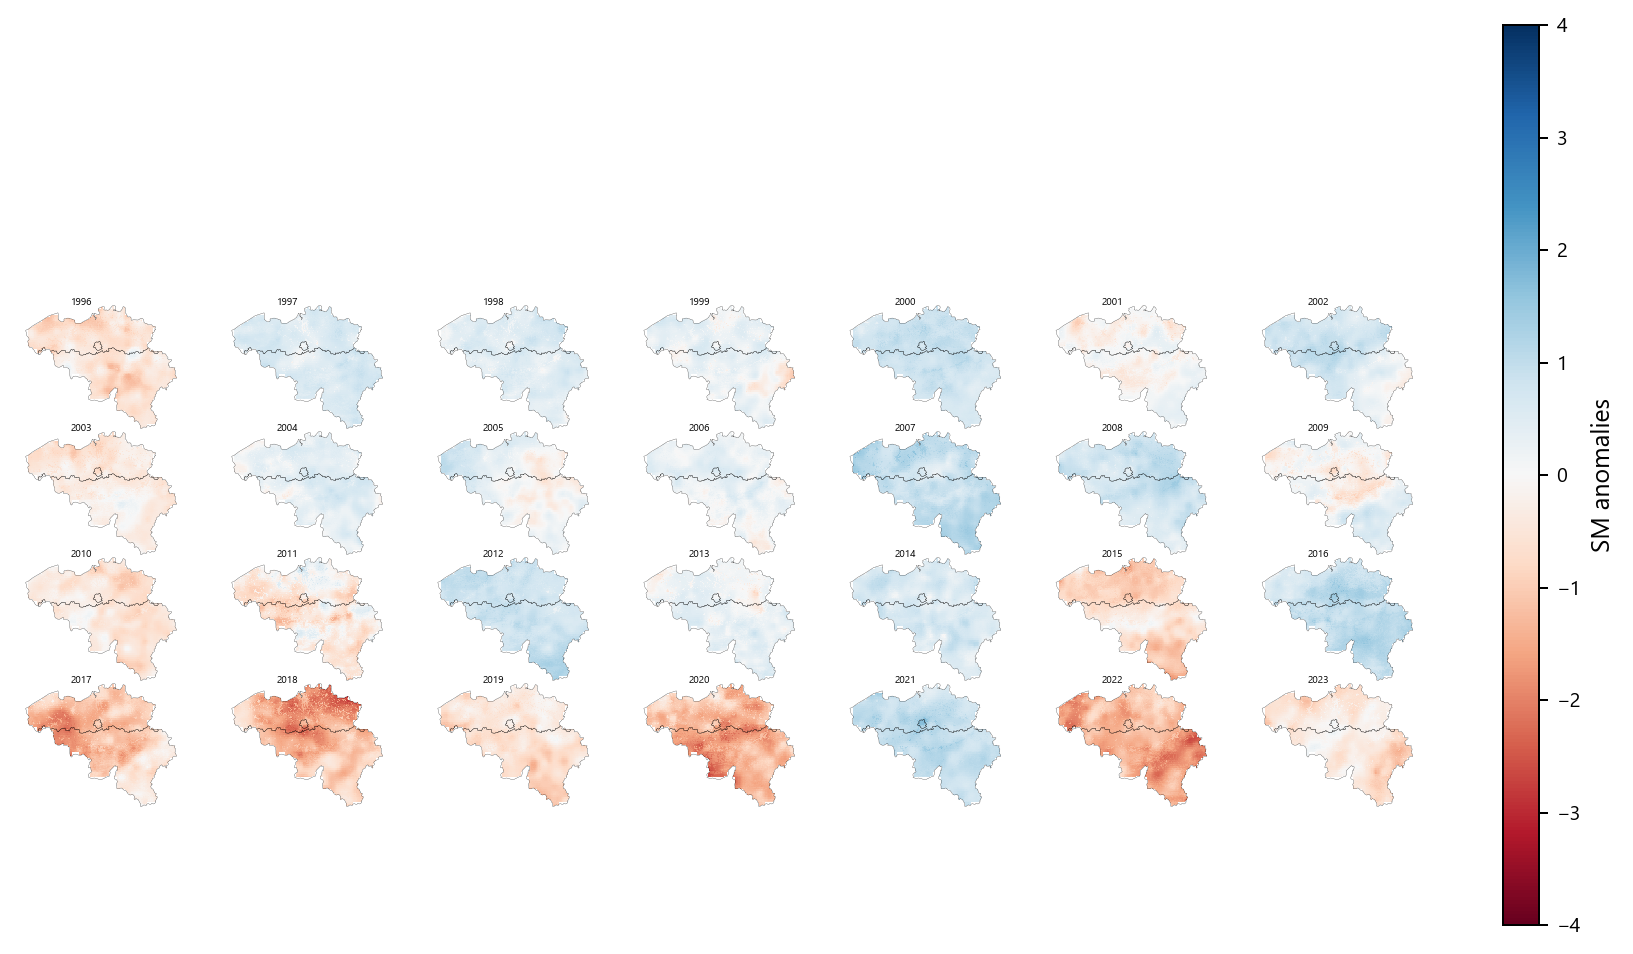

In [8]:
fig, ax = plt.subplots(10, 7,subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10), dpi=180)
# Flatten the 2D array of axes
axes = ax.flatten()
plt.subplots_adjust(hspace=-0.5, wspace=0.3)
# Loop through each time slice and its corresponding subplot
for i, time in enumerate(summer_average_anomaly.year.values):
    if i < len(axes):  # Ensure we do not exceed the number of subplots
        im = summer_average_anomaly['SM_L02'].sel(year=time).plot(
            ax=axes[i], cmap='RdBu',
            robust=True,
            vmin=-4,
            vmax=4,
            add_colorbar=False
        )
        axes[i].set_title(str(time), fontsize=4, x=0.4, y=0.85)  # Add a small title to each plot
        be_shp.boundary.plot(ax=axes[i], edgecolor='black', linewidth=0.1)
        # Remove the frame
        axes[i].set_frame_on(False)
    else:
        break
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
# Add a shared colorbar
cbar_ax = fig.add_axes([0.95, 0.5, 0.02, 0.5])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='SM anomalies')
cbar_ax.tick_params(labelsize=8)
plt.show()

#### Stacked area anomalies

In [ ]:
# Drop NaN values before calculating percentiles
valid_values = summer_anomalies['SM_L02'].values[~np.isnan(summer_anomalies['SM_L02'].values)]

# Define the percentiles
percentiles = [2,5,10,20,30,50,70,95]
percentile_labels = ['Exceptionally dry', 'Extreme drought', 'Severe drought', 'Moderate drought', 'Abnormally dry','Normal conditions','Wetter than normal', 'Very wet', 'Extremely wet']

# Calculate the percentile thresholds for the valid dataset
thresholds = np.percentile(valid_values, percentiles)

# Include bounds for categories
bounds = [-np.inf] + list(thresholds) + [np.inf]


# Group by year and classify data
results = []
for year, data in summer_anomalies.groupby('time.year'):
    # Classify data into percentile bins
    binned = xr.apply_ufunc(
        np.digitize,
        data['SM_L02'],
        input_core_dims=[[]],
        kwargs={'bins': bounds},
    )
    
    # Count the number of values in each bin
    counts = [(binned == i).sum().item() for i in range(1, len(bounds))]
    results.append([year] + counts)

# Convert results into a DataFrame
df = pd.DataFrame(results, columns=['Year'] + percentile_labels)

# Normalize (if needed)
# If you want relative percentages, divide by total grid cells
df.iloc[:, 1:] = df.iloc[:, 1:].div(df.iloc[:, 1:].sum(axis=1), axis=0) * 100

# Plot the stacked area chart
fig, ax = plt.subplots(figsize=(12, 2.5),dpi=300)
ax.stackplot(df.Year, df.iloc[:,[1,2,3,4,5,6]].T, labels=percentile_labels[0:6], colors = ['darkred','red','darkorange','gold','yellow','paleturquoise'])
ax.set_ylabel("% Area")
ax.legend(loc='upper center', bbox_to_anchor=(0.35, 0.98), ncols =3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.axvline(pd.to_datetime('1976'))
plt.show()

In [3]:
BESMI = xr.open_dataset("W:/VUB/_main_research/mHM/mhm_outputs/mHM_EOBS/SMI.nc")

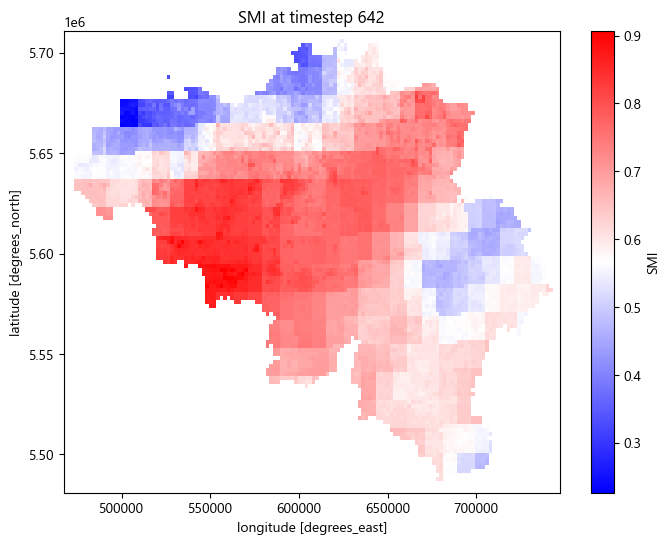

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Load and mask SMI
BESMI = xr.open_dataset("W:/VUB/_main_research/mHM/mhm_outputs/mHM_EOBS/SMI.nc")
BESMI = BESMI.where(BESMI['SMI'] > 0)

# Plot a specific timestep (642)
plt.figure(figsize=(8, 6))
#BESMI['SMI'].isel(time=90).plot(cmap='bwr', add_colorbar=True, cbar_kwargs={'label': 'SMI'})
plt.title("SMI at timestep 642")
plt.show()